## Вычисление скорости обучения

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Flatten, Reshape, LSTM, Dropout
from keras.models import Model, Sequential
import keras
from sklearn.metrics import mean_squared_error, classification_report, precision_recall_curve
import seaborn as sns
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader

In [3]:
%%time
df = pd.read_csv('dep_delay_df.csv')
df.drop(['YEAR','FLIGHTS', 'DEP_DELAY_GROUP'], axis=1, inplace=True)
df.FIRST_DEP_TIME.fillna(0, inplace=True)
#flights.TOTAL_ADD_GTIME.fillna(0, inplace=True)
df.LONGEST_ADD_GTIME.fillna(0, inplace=True)
#df.drop('LONGEST_ADD_GTIME', axis=1, inplace=True)
df.drop('TOTAL_ADD_GTIME', axis=1, inplace=True)
#df.drop('FIRST_DEP_TIME', axis=1, inplace=True)
df.STD_DELAY.fillna(0, inplace=True)
df.MEAN_DELAY.fillna(0, inplace=True)
df.MAX_DELAY.fillna(0, inplace=True)
df.MIN_DELAY.fillna(0, inplace=True)
df.COUNT.fillna(0, inplace=True)
df['25%_DELAY'].fillna(0, inplace=True)
df['50%_DELAY'].fillna(0, inplace=True)
df['75%_DELAY'].fillna(0, inplace=True)
df.dropna(inplace=True)

CPU times: user 24.3 s, sys: 13.3 s, total: 37.6 s
Wall time: 44.2 s


In [4]:
def fill_dep_delay(x):
    if x >= 15:
        return 1
    return 0

In [5]:
df['DEP_DELAY'] = df['DEP_DELAY'].apply(fill_dep_delay)

In [6]:
scaler = MinMaxScaler()

In [7]:
y = df.DEP_DELAY
df.drop('DEP_DELAY', axis=1, inplace=True)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train)

In [9]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [10]:
test_dataset = TensorDataset(
    torch.tensor(x_test.astype(np.float32)),
    torch.tensor(y_test.values.astype(np.long))
)

In [11]:
batch_size=256

In [12]:
train_dataset = TensorDataset(
    torch.tensor(x_train.astype(np.float32)),
    torch.tensor(y_train.values.astype(np.long))
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(
    torch.tensor(x_test.astype(np.float32)),
    torch.tensor(y_test.values.astype(np.long))
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(
    torch.tensor(x_val.astype(np.float32)),
    torch.tensor(y_val.values.astype(np.long))
)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class SimpleNet(nn.Module):
    
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(54, 38)
        self.fc2 = nn.Linear(38, 38)
        self.fc3 = nn.Linear(38, 2)
        
    def forward(self, x):
        x = x.view(-1, 54)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            #correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [15]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [16]:
x_train.shape

(2665560, 54)

In [17]:
simplenet = SimpleNet()

In [18]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

In [98]:
train(simplenet, optimizer, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=5)

<ipython-input-94-a2c19f1676e6>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 0.35, Validation Loss: 0.35, accuracy = 0.87
Epoch: 2, Training Loss: 0.35, Validation Loss: 0.34, accuracy = 0.87
Epoch: 3, Training Loss: 0.34, Validation Loss: 0.34, accuracy = 0.87
Epoch: 4, Training Loss: 0.34, Validation Loss: 0.34, accuracy = 0.87
Epoch: 5, Training Loss: 0.34, Validation Loss: 0.34, accuracy = 0.87


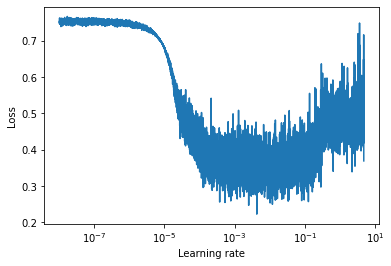

In [19]:
(lrs, losses) = find_lr(simplenet, torch.nn.CrossEntropyLoss(), optimizer, train_loader)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

Text(0, 0.5, 'Loss')

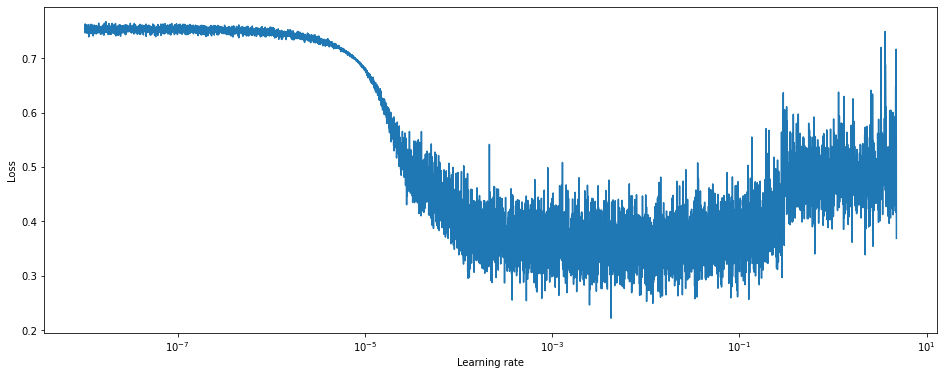

In [20]:
plt.figure(figsize=(16,6))
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [21]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

Text(0, 0.5, 'Значение функции потерь')

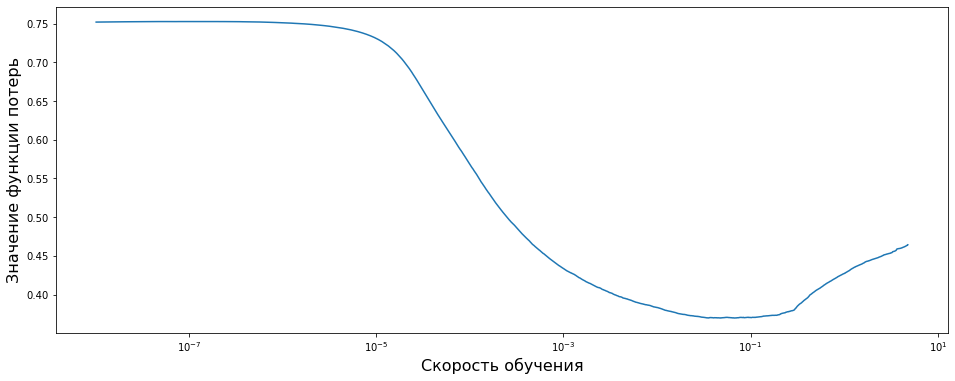

In [25]:
plt.figure(figsize=(16,6))
plt.plot(lrs, exponential_smoothing(pd.Series(losses), 0.001))
plt.xscale("log")
plt.xlabel("Скорость обучения", fontsize=16)
plt.ylabel("Значение функции потерь", fontsize=16)

In [121]:
(lrs, losses) = find_lr(simplenet, torch.nn.CrossEntropyLoss(), optimizer, train_loader,
                        init_value=1e-5, final_value=1e-3)

Text(0, 0.5, 'Loss')

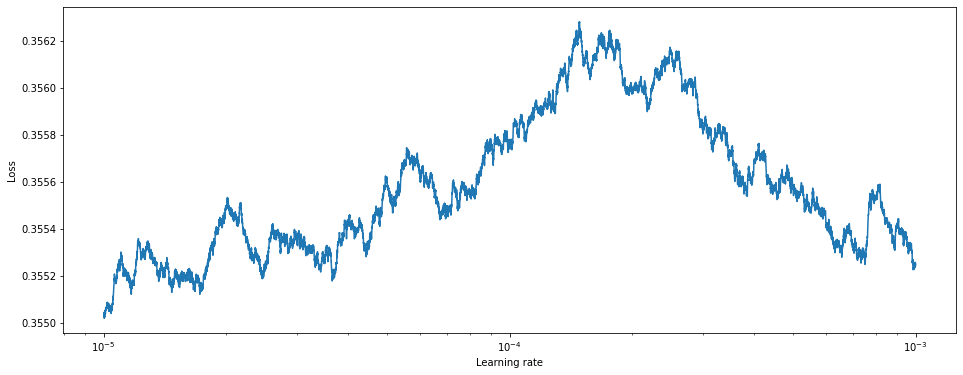

In [131]:
plt.figure(figsize=(16,6))
plt.plot(lrs, exponential_smoothing(pd.Series(losses), 0.0001))
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")